In [1]:
%matplotlib inline

import sys
sys.path.append("../")
from utils import DetectionDataset
from utils import draw_rectangle
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.random.seed(10)

# \[ SSD Prior Boxes \]
----
----

우리는 각 Feature Map 마다 가상의 box인 Default Box를 둡니다. 이 Default Box는 Multi-Head Network가 물체를 잡을 때 기준이 되는 Box로, Default Box에 물체가 Threhold 이상 겹쳤을 때에만 동작하도록 구성됩니다. 그렇기 때문에, Default Box을 어떻게 설정하느냐에 따라 성능에 주요한 차이를 보이게 됩니다.

## 1. DetectionDataset 가져오기
---

무작위로 300개 가량의 이미지를 불러오도록 하겠습니다. 영상 내 존재하는 글자들의 크기가 대략 얼마만큼 되는지를 파악해보도록 하겠습니다.

### (1) Dataset 불러오기

In [2]:
dataset = DetectionDataset(data_type='validation')
images, ground_truths = dataset[0:300]

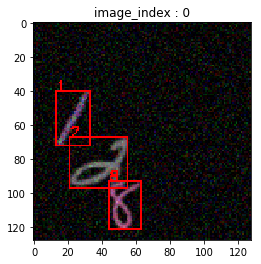

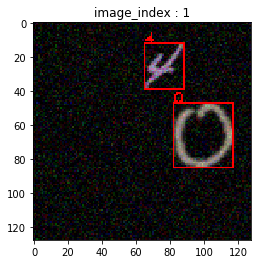

In [3]:
num_show = 2
for image, (image_index, gt_df) in zip(images, 
                                    ground_truths.groupby('image_index')):
    vis_image = draw_rectangle(image, gt_df)
    plt.title(f"image_index : {image_index}")
    plt.imshow(vis_image)
    plt.show()

    if num_show <=1:
        break
    num_show-=1

### (2) 글자 폭과 높이의 분포 확인하기

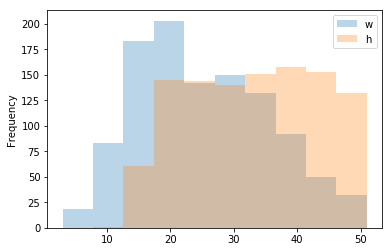

In [4]:
ground_truths[['w','h']].plot(kind='hist', alpha=0.3)
plt.show()

대부분의 박스가 10~50 사이에 위치하게 됩니다. Default Box의 크기(Scale)를 10, 25, 40으로 두도록 하겠습니다.

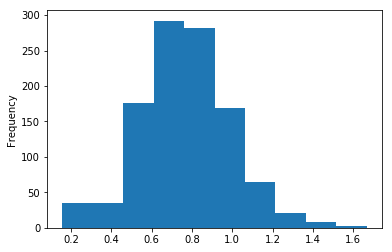

In [5]:
(ground_truths.w/ground_truths.h).plot('hist')
plt.show()

글자의 가로/세로 비율($\frac{width}{height}$)은 0.2~1.6까지 분포합니다.

## 2. Prior Box 구성하기
----

![Imgur](https://i.imgur.com/w13KPxL.png)

Prior Boxes란 각 Feature Map에서 사물을 포착하는 기준이 되는 `가상의 Box`를 의미합니다. Multi-box Head Network는 이 가상의 박스를 기준으로, 해당 박스 내에 사물이 겹쳐져 있으면 해당 위치에 사물이 존재한다고 파악하고, 이 가상의 박스를 기준으로 박스 내에 사물이 없으면 존재하지 않는다고 파악합니다. 그렇기 때문에, 이 가상의 박스 크기와 형태를 어떻게 정하냐가 성능에 지대한 영향을 미칩니다.

### (1) Prior Box의 크기 산정하기


우리는 위에서 Prior box의 Scale은 $[10,25,40]$로 두고, Prior Box의 Ratio은 $ [(1,1),(1.5,0.5),(1.2,0.8),(0.8,1.2),(1.4,1.4)]$로 두었습니다. Scale은 각 Source Layer에 매칭됩니다. 얕은 층의 Source Layer는 영상에서 세밀한 정보를 가지고 있고, 깊은 층의 Source Layer은 영상에서 전체적인 정보를 가지고 있습니다. 그렇기 때문에 작은 사물을 잡을 때에는 얕은 층의 Layer가 유리하고, 큰 사물을 잡을 때에는 깊은 층의 Layer가 유리합니다.

In [6]:
strides = [4, 8, 16]
scales = [10, 25, 40]
ratios = [(1,1),     # ratio : 1.
          (1.5,0.5), # ratio : 0.33
          (1.2,0.8), # ratio : 0.67
          (0.8,1.2), # ratio : 1.5
          (1.4,1.4)]

bbox_df = pd.DataFrame(columns=['stride', 'w', 'h'])
for scale, stride in zip(scales, strides):
    for ratio in ratios:
        w = np.round(scale * ratio[0]).astype(np.int)
        h = np.round(scale * ratio[1]).astype(np.int)
        bbox_df.loc[len(bbox_df) + 1] = [stride, w, h]

bbox_df.stride = bbox_df.stride.astype(np.int)
bbox_df.w = bbox_df.w.astype(np.int)
bbox_df.h = bbox_df.h.astype(np.int)

### (2) Feature Map의 각 점에 Prior Box 배치하기

위에서 주어진 Default box의 Feature Map이 아래와 같이 주어지게 됩니다.

In [7]:
height, width = image.shape[:2]
multi_boxes = []
for stride, df in bbox_df.groupby('stride'):
    boxes = []
    for idx, row in df.iterrows():
        stride, box_width, box_height = row.stride, row.w, row.h
        ys, xs = np.mgrid[0:height:stride, 0:width:stride]
        box_width = np.ones_like(xs) * box_width
        box_height = np.ones_like(ys) * box_height
        center_xs = stride//2 + xs
        center_ys = stride//2 + ys

        block_centers = np.stack((center_xs, center_ys, 
                                  box_width, box_height),
                                 axis=-1)
        boxes.append(block_centers)
    boxes = np.stack(boxes, axis=2)
    multi_boxes.append(boxes)

위의 정보를 시각화하면 아래와 같습니다.

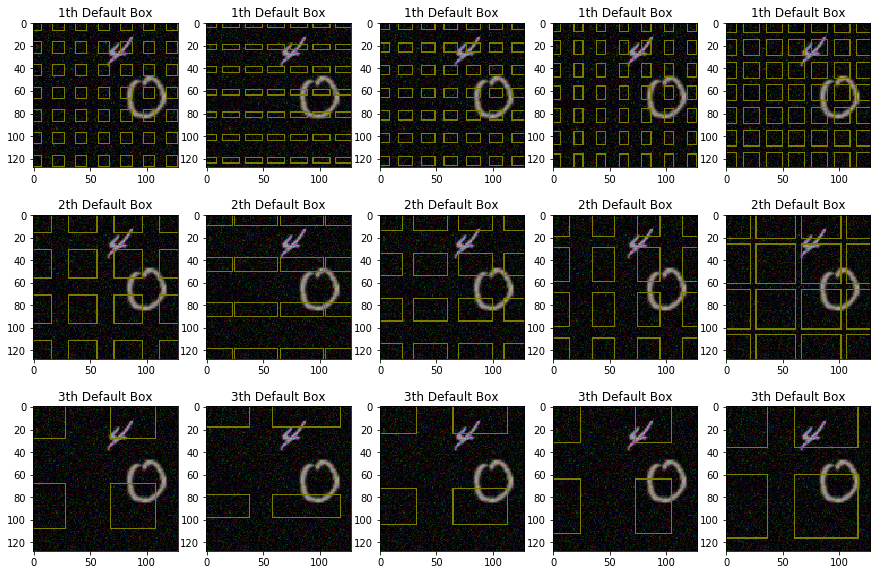

In [8]:
fig = plt.figure(figsize=(15,10))

for i in range(3):
    for j in range(5):
        boxes = multi_boxes[i][::5,::5,j,:].reshape(-1,4)
        visualized = draw_rectangle(image, boxes,
                                    color=(125,125,0))
        ax = fig.add_subplot(3,5,i*5+j+1)
        ax.set_title(f"{i+1}th Default Box")
        ax.imshow(visualized)
plt.show()

위의 작업을 메소드로 구현하면 아래와 같이 됩니다. `Default boxes`를 사전 정보를 의미하는 `prior boxes`로 바꾸어 명명하겠습니다.

In [9]:
class PriorBoxes:
    """
    Default Box Configuration Class
    """
    bbox_df = pd.DataFrame()

    def __init__(self, strides, scales, ratios):
        self.strides = strides
        self.scales = scales
        self.ratios = ratios
        self.setup()

    def generate(self, image_shape):
        """
        image_shape에 맞춰서, Prior Box(==Default Boxes)를 구성

        return :
        (# Prior boxes, 4)로 이루어진 출력값 생성
        """
        height, width = image_shape[:2]
        multi_boxes = []
        for stride, df in self.bbox_df.groupby('stride'):
            boxes = []
            for idx, row in df.iterrows():
                stride, box_width, box_height = row.stride, row.w, row.h
                ys, xs = np.mgrid[0:height:stride, 0:width:stride]
                box_width = np.ones_like(xs) * box_width
                box_height = np.ones_like(ys) * box_height
                center_xs = stride // 2 + xs
                center_ys = stride // 2 + ys

                block_centers = np.stack((center_xs, center_ys,
                                          box_width, box_height),
                                         axis=-1)
                boxes.append(block_centers)
            boxes = np.stack(boxes, axis=2)
            boxes = np.reshape(boxes, (-1, 4))
            multi_boxes.append(boxes)
        multi_boxes = np.concatenate(multi_boxes, axis=0)
        return multi_boxes

    def setup(self):
        bbox_df = pd.DataFrame(columns=['stride', 'w', 'h'])
        for scale, stride in zip(self.scales, self.strides):
            for ratio in self.ratios:
                w = np.round(scale * ratio[0]).astype(np.int)
                h = np.round(scale * ratio[1]).astype(np.int)
                bbox_df.loc[len(bbox_df) + 1] = [stride, w, h]

        bbox_df.stride = bbox_df.stride.astype(np.int)
        bbox_df.w = bbox_df.w.astype(np.int)
        bbox_df.h = bbox_df.h.astype(np.int)
        self.bbox_df = bbox_df

## 3. Matching Strategy 구현하기
----

우리는 학습을 시킬 때, Prior Box가 최소 50%이상 겹친 박스에 대해서만, 사물이 있다고 판정하고 학습을 시킵니다. 50% 미만으로 겹친 박스들은 전부 Background라고 판정합니다.<br>
우리는 Prior Box와 사물이 있는 박스를 위미하는 Ground Truth Box를 각각 서로 얼마나 겹치는지를 계산해야 합니다. 

![Imgur](https://i.imgur.com/mnlYIBL.png)

우리는 위와 같이 $(x_{min},y_{min},x_{max},y_{max})$을 가지고 겹친 넓이를 구할 수 있습니다.

In [24]:
np.random.seed(10) # 결과가 같도록 고정
image, ground_truths = dataset[0]

In [25]:
gt_boxes = ground_truths.iloc[:,1:5].values
gt_labels = ground_truths.iloc[:,-1].values

prior = PriorBoxes(strides,scales,ratios)

pr_boxes = prior.generate(image.shape)
print("gt boxes의 shape : ", gt_boxes.shape)
print("prior boxes의 shape :", pr_boxes.shape)

gt boxes의 shape :  (3, 4)
prior boxes의 shape : (6720, 4)


우리는 동시에 GT Boxes와 Prior Boxes의 IOU를 계산하기 위해서는 아래와 같이 두 벡터를 Pivoting하면 됩니다.

![Imgur](https://i.imgur.com/x9wuyp4.png)

In [ ]:
# 1. pivot bounding boxes 
exp_gt_boxes = gt_boxes[:,None] # Ground truth box가 행 기준으로 정렬되도록
exp_pr_boxes = pr_boxes[None,:] # prior box가 열 기준으로 정렬되도록

# 2. calculate intersection over union
# 2.1. Calculate Intersection
gt_cx, gt_cy, gt_w, gt_h = exp_gt_boxes.transpose(2,0,1)
pr_cx, pr_cy, pr_w, pr_h = exp_pr_boxes.transpose(2,0,1)

# (cx,cy,w,h) -> (xmin,ymin,xmax,ymax)
gt_xmin, gt_xmax = gt_cx-gt_w/2, gt_cx+gt_w/2
gt_ymin, gt_ymax = gt_cy-gt_h/2, gt_cy+gt_h/2
pr_xmin, pr_xmax = pr_cx-pr_w/2, pr_cx+pr_w/2
pr_ymin, pr_ymax = pr_cy-pr_h/2, pr_cy+pr_h/2

# 겹친 사각형의 너비와 높이 구하기
in_xmin = np.maximum(gt_xmin, pr_xmin)
in_xmax = np.minimum(gt_xmax, pr_xmax)
in_width = in_xmax - in_xmin
in_width[in_width<0] = 0

in_ymin = np.maximum(gt_ymin, pr_ymin)
in_ymax = np.minimum(gt_ymax, pr_ymax)
in_height = in_ymax - in_ymin
in_height[in_height<0] = 0

# 겹친 사각형의 넓이 구하기
intersection = in_width*in_height

gt_sizes = exp_gt_boxes[...,2] * exp_gt_boxes[...,3]
pr_sizes = exp_pr_boxes[...,2] * exp_pr_boxes[...,3]

# 2.2. Calculate Union
union = (gt_sizes + pr_sizes) - intersection

# Result
iou = (intersection / (union+1e-5)) # 0 나누기 방지를 위함

위의 알고리즘을 메소드로 구현하면 아래와 같습니다.

In [42]:
def calculate_iou(gt_boxes,pr_boxes):
    # 1. pivot bounding boxes 
    exp_gt_boxes = gt_boxes[:,None] # Ground truth box가 행 기준으로 정렬되도록
    exp_pr_boxes = pr_boxes[None,:] # prior box가 열 기준으로 정렬되도록

    # 2. calculate intersection over union
    # 2.1. Calculate Intersection
    gt_cx, gt_cy, gt_w, gt_h = exp_gt_boxes.transpose(2,0,1)
    pr_cx, pr_cy, pr_w, pr_h = exp_pr_boxes.transpose(2,0,1)

    # (cx,cy,w,h) -> (xmin,ymin,xmax,ymax)
    gt_xmin, gt_xmax = gt_cx-gt_w/2, gt_cx+gt_w/2
    gt_ymin, gt_ymax = gt_cy-gt_h/2, gt_cy+gt_h/2
    pr_xmin, pr_xmax = pr_cx-pr_w/2, pr_cx+pr_w/2
    pr_ymin, pr_ymax = pr_cy-pr_h/2, pr_cy+pr_h/2

    # 겹친 사각형의 너비와 높이 구하기
    in_xmin = np.maximum(gt_xmin, pr_xmin)
    in_xmax = np.minimum(gt_xmax, pr_xmax)
    in_width = in_xmax - in_xmin
    in_width[in_width<0] = 0

    in_ymin = np.maximum(gt_ymin, pr_ymin)
    in_ymax = np.minimum(gt_ymax, pr_ymax)
    in_height = in_ymax - in_ymin
    in_height[in_height<0] = 0

    # 겹친 사각형의 넓이 구하기
    intersection = in_width*in_height

    gt_sizes = exp_gt_boxes[...,2] * exp_gt_boxes[...,3]
    pr_sizes = exp_pr_boxes[...,2] * exp_pr_boxes[...,3]

    # 2.2. Calculate Union
    union = (gt_sizes + pr_sizes) - intersection

    # 0 나누기 방지를 위함
    return (intersection / (union+1e-5))

In [43]:
iou = calculate_iou(gt_boxes, pr_boxes)

iou_threshold = 0.5
match_indices = np.argwhere(iou>=iou_threshold)
print(match_indices.shape)

(24, 2)


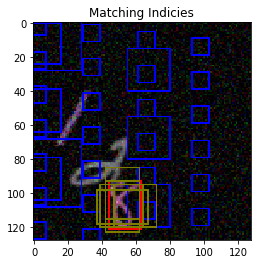

In [44]:
target_indices = match_indices[match_indices[:,0]==2]

visualized = draw_rectangle(image, pr_boxes[::200],
                            color=(0,0,255))
visualized = draw_rectangle(visualized, gt_boxes[target_indices[:,0]],
                            color=(255,0,0))
visualized = draw_rectangle(visualized, pr_boxes[target_indices[:,1]],
                            color=(125,125,0))

plt.title("Matching Indicies")
plt.imshow(visualized)
plt.show()

## 3. Training Objective 구성하기
----

우리의 목표는 Matching된 Prior Box에 있는 숫자를 `multi-box head Network`로<br>
(1) 어떤 숫자인지 파악하고 (2) 숫자의 위치가 어디에 있는지를 파악하는데에 이용하고자 합니다.

즉 모델에서 예측하고자 하는 출력의 형태로 우리는 바꾸어 주어야 합니다.

In [39]:
from models.ssd import build_base_network, attach_multibox_head

In [40]:
base_network = build_base_network(input_shape=(None,None,3),num_units=16)
predictions = attach_multibox_head(base_network,['norm3_2','norm4_2','norm5_2'])
model = Model(base_network.input, predictions)

W0725 16:11:27.772358 4728780224 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### (1) Classification Network의 정답 구성하기

우리는 match_indices에 포함된 것들 제외하고는 모두 Background로 라벨링을 해주어야 ㅎ바니다

In [41]:
from tensorflow.keras.utils import to_categorical

In [42]:
gt_labels = ground_truths.iloc[:,-1].values

num_classes = 10

y_true_clf = np.ones((pr_boxes.shape[0])) * num_classes # Background로 일단 채움
y_true_clf[match_indices[:,1]] = gt_labels[match_indices[:,0]]

y_true_clf = to_categorical(y_true_clf, 
                            num_classes=num_classes+1) # One-Hot Encoding
y_true_clf

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [43]:
y_true_clf[y_true_clf[...,-1]!=1.]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.

### (2) Localization Network의 정답 구성하기

Localization Network는 Prior Box내에 있는 사물의 위치를 보정하여 줍니다. 보정 수식은 아래와 같습니다.<br>
$
y_{true}^{loc} = (\hat g^{cx},\hat g^{cy}, \hat g^{w},\hat g^{h}) \\
\hat g^{cx} = \frac{(g^{cx} - p^{cx})}{p^{w}} \\
\hat g^{cy} = \frac{(g^{cy} - p^{cy})}{p^{h}} \\
\hat g^{w} = log(\frac{g^{w}}{p^{w}}) \\
\hat g^{h} = log(\frac{g^{h}}{p^{h}}) \\
$

In [44]:
y_true_loc = np.zeros((pr_boxes.shape[0],4))
g_cx, g_cy, g_w, g_h = gt_boxes[match_indices[:,0]].transpose()
p_cx, p_cy, p_w, p_h = pr_boxes[match_indices[:,1]].transpose()

hat_g_cx = (g_cx - p_cx) / p_w
hat_g_cy = (g_cy - p_cy) / p_h
hat_g_w = np.log(g_w / p_w)
hat_g_h = np.log(g_h / p_h)

hat_g = np.stack([hat_g_cx,hat_g_cy,hat_g_w,hat_g_h],axis=1)
y_true_loc[match_indices[:,1]] = hat_g
y_true_loc

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [45]:
y_true_loc[match_indices[:,1]]

array([[-0.02      ,  0.38      , -0.08338161,  0.39204209],
       [ 0.21428571,  0.04285714, -0.41985385,  0.05556985],
       [-0.02      ,  0.06      , -0.08338161,  0.39204209],
       [-0.025     ,  0.05      ,  0.13976194,  0.20972053],
       [-0.01428571,  0.04285714, -0.41985385,  0.05556985],
       [-0.24285714,  0.04285714, -0.41985385,  0.05556985],
       [-0.02      , -0.26      , -0.08338161,  0.39204209],
       [-0.025     , -0.21666667,  0.13976194,  0.20972053],
       [-0.1125    , -0.0625    , -0.55338524, -0.07796154],
       [-0.140625  , -0.05208333, -0.33024169, -0.2602831 ],
       [ 0.31428571,  0.04285714,  0.22884157,  0.10821358],
       [ 0.08571429,  0.04285714,  0.22884157,  0.10821358],
       [-0.14285714,  0.04285714,  0.22884157,  0.10821358],
       [ 0.08571429, -0.18571429,  0.22884157,  0.10821358],
       [-0.14285714, -0.18571429,  0.22884157,  0.10821358],
       [ 0.175     , -0.0625    ,  0.09531018, -0.02531781],
       [ 0.14583333, -0.

이후에 이 값을 복원하기 위해서는 아래 수식을 이용하면 됩니다.<br>

$
cx_{restore} = \hat g^{cx} * d^w +d^{cx} \\
cy_{restore} = \hat g^{cy} * d^h +d^{cy} \\
w_{restore} = exp^{\hat g^{w}} * d^w \\
h_{restore} = exp^{\hat g^{h}} * d^h \\
$

In [46]:
# 복원 후 동일한지 확인하기
res_cx = (y_true_loc[:,0] 
          * pr_boxes[:,2] 
          + pr_boxes[:,0])
res_cy = (y_true_loc[:,1] 
          * pr_boxes[:,3] 
          + pr_boxes[:,1])
res_w = (np.exp(y_true_loc[:,2])
         *pr_boxes[:,2])
res_h = (np.exp(y_true_loc[:,3])
         *pr_boxes[:,3])

restore_boxes = np.stack([res_cx,res_cy,res_w,res_h], axis=-1)

np.testing.assert_array_almost_equal(gt_boxes[match_indices[:,0]],
                                     restore_boxes[match_indices[:,1]])

### (3) SSD Network의 정답값 구성하기

In [47]:
y_true = np.concatenate([y_true_clf, y_true_loc],axis=1)
y_true.shape

(6720, 15)

---